In [245]:
# import relevant libraries

# basic libraries
import pandas as pd
import numpy as np
from collections import Counter

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries
from sklearn import tree, metrics, model_selection, linear_model, ensemble, preprocessing

# data collection libraries
import requests
from selenium import webdriver
import bs4
import imdbpie
import json

%matplotlib inline

# Identify: Problem Statement & Goals

**Using data from IMDB, can we build a model that predicts movie ratings based on certain inputs?**

- Predict movie ratings using information about the movie (e.g. genre, length of movie etc.)
- What are the factors that affect movie rating?

# Acquire: Query IMDB, write results, scrape IMDB

## Using IMDBpie

In [3]:
imdb = imdbpie.Imdb()

In [4]:
imdb_df = pd.read_json(json.dumps(imdb.top_250()))

In [5]:
imdb_df.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'https://images-na.ssl-images-amazon...,1721713,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'https://images-na.ssl-images-amazon...,1176659,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'https://images-na.ssl-images-amazon...,806532,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'https://images-na.ssl-images-amazon...,1707517,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'https://images-na.ssl-images-amazon...,458772,8.9,tt0050083,12 Angry Men,feature,1957


In [6]:
top_250_id = imdb_df["tconst"]

In [11]:
# IMDB API URL
api_url = "http://www.omdbapi.com/?i={}&plot=full&r=json"

In [12]:
# path to phantomjs
phan_path = "//Applications/phantomjs"

In [13]:
def get_content(id_num):
    r = requests.get(api_url.format(id_num))
#     tmp = pd.DataFrame(json.loads(r.text), index=[0])
    tmp = json.loads(r.text)
    return tmp

In [14]:
df = pd.DataFrame([get_content(i) for i in top_250_id])

In [15]:
df.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 18 wins & 30 n...,USA,Frank Darabont,"Crime, Drama",English,80,Chronicles the experiences of a formerly succe...,https://images-na.ssl-images-amazon.com/images...,R,14 Oct 1994,True,142 min,The Shawshank Redemption,movie,"Stephen King (short story ""Rita Hayworth and S...",1994,tt0111161,9.3,"1,711,064"
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100,When the aging head of a famous crime family d...,https://images-na.ssl-images-amazon.com/images...,R,24 Mar 1972,True,175 min,The Godfather,movie,"Mario Puzo (screenplay), Francis Ford Coppola ...",1972,tt0068646,9.2,"1,169,904"
2,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",Won 6 Oscars. Another 10 wins & 20 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Spanish, Latin, Sicilian",80,The continuing saga of the Corleone crime fami...,https://images-na.ssl-images-amazon.com/images...,R,20 Dec 1974,True,202 min,The Godfather: Part II,movie,"Francis Ford Coppola (screenplay), Mario Puzo ...",1974,tt0071562,9.0,"800,469"
3,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Won 2 Oscars. Another 146 wins & 142 nominations.,"USA, UK",Christopher Nolan,"Action, Crime, Drama","English, Mandarin",82,When the menace known as the Joker wreaks havo...,https://images-na.ssl-images-amazon.com/images...,PG-13,18 Jul 2008,True,152 min,The Dark Knight,movie,"Jonathan Nolan (screenplay), Christopher Nolan...",2008,tt0468569,9.0,"1,699,835"
4,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",Nominated for 3 Oscars. Another 16 wins & 8 no...,USA,Sidney Lumet,"Crime, Drama",English,N/A,The defense and the prosecution have rested an...,https://images-na.ssl-images-amazon.com/images...,APPROVED,01 Apr 1957,True,96 min,12 Angry Men,movie,"Reginald Rose (story), Reginald Rose (screenplay)",1957,tt0050083,8.9,"455,987"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
Actors        250 non-null object
Awards        250 non-null object
Country       250 non-null object
Director      250 non-null object
Genre         250 non-null object
Language      250 non-null object
Metascore     250 non-null object
Plot          250 non-null object
Poster        250 non-null object
Rated         250 non-null object
Released      250 non-null object
Response      250 non-null object
Runtime       250 non-null object
Title         250 non-null object
Type          250 non-null object
Writer        250 non-null object
Year          250 non-null object
imdbID        250 non-null object
imdbRating    250 non-null object
imdbVotes     250 non-null object
dtypes: object(20)
memory usage: 39.1+ KB


# Mine: Rename & describe data

In [17]:
df2 = df.copy()

In [18]:
languages = []

In [19]:
for i in df2["Language"]:
    languages.extend(i.split(","))

In [20]:
len(languages)

458

In [21]:
languages = set(languages)

In [22]:
len(languages)

54

In [23]:
for i in languages:
    df2["language_"+i] = df2["Language"].map(lambda x: 1 if i in x else 0)

In [24]:
def oscars_won(i):
    i_list = i.split()
    if "Oscars." in i.split() and i_list[i_list.index("Oscars.")-2] == "Won":
        return i_list[i_list.index("Oscars.")-1]
    else:
        return 0

In [25]:
df2["Oscars_won"] = df2["Awards"].map(oscars_won)

In [26]:
country = []
for i in df2["Country"]:
    country.extend(i.split(","))
country = set(country)

In [27]:
for i in country:
    df2["country_"+i] = df2["Country"].map(lambda x: 1 if i in x else 0)

In [44]:
features = ["Year" , "imdbVotes" , "language_ English", "Oscars_won" , "country_USA"]

In [45]:
df2.to_csv("test_data.csv", encoding="utf-8")

In [84]:
df2 = pd.read_csv("test_data.csv", encoding="utf-8").iloc[:,1:21]

In [85]:
df2.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,Released,Response,Runtime,Title,Type,Writer,Year,imdbID,imdbRating,imdbVotes
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 18 wins & 30 n...,USA,Frank Darabont,"Crime, Drama",English,80.0,Chronicles the experiences of a formerly succe...,https://images-na.ssl-images-amazon.com/images...,R,14 Oct 1994,True,142 min,The Shawshank Redemption,movie,"Stephen King (short story ""Rita Hayworth and S...",1994,tt0111161,9.3,1711064.0
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100.0,When the aging head of a famous crime family d...,https://images-na.ssl-images-amazon.com/images...,R,24 Mar 1972,True,175 min,The Godfather,movie,"Mario Puzo (screenplay), Francis Ford Coppola ...",1972,tt0068646,9.2,1169904.0
2,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",Won 6 Oscars. Another 10 wins & 20 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Spanish, Latin, Sicilian",80.0,The continuing saga of the Corleone crime fami...,https://images-na.ssl-images-amazon.com/images...,R,20 Dec 1974,True,202 min,The Godfather: Part II,movie,"Francis Ford Coppola (screenplay), Mario Puzo ...",1974,tt0071562,9.0,800469.0
3,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Won 2 Oscars. Another 146 wins & 142 nominations.,"USA, UK",Christopher Nolan,"Action, Crime, Drama","English, Mandarin",82.0,When the menace known as the Joker wreaks havo...,https://images-na.ssl-images-amazon.com/images...,PG-13,18 Jul 2008,True,152 min,The Dark Knight,movie,"Jonathan Nolan (screenplay), Christopher Nolan...",2008,tt0468569,9.0,1699835.0
4,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",Nominated for 3 Oscars. Another 16 wins & 8 no...,USA,Sidney Lumet,"Crime, Drama",English,NaN,The defense and the prosecution have rested an...,https://images-na.ssl-images-amazon.com/images...,APPROVED,01 Apr 1957,True,96 min,12 Angry Men,movie,"Reginald Rose (story), Reginald Rose (screenplay)",1957,tt0050083,8.9,455987.0


In [86]:
def oscars_won(i):
    i_list = str(i).split()
    if "Oscars." in i_list and i_list[i_list.index("Oscars.")-2] == "Won":
        return float(i_list[i_list.index("Oscars.")-1])
    else:
        return 0

In [87]:
df2["Oscars_won"] = df2["Awards"].map(oscars_won)

In [88]:
# Let"s consider the language the movie is available in
# For model simplicity, we'll consider just the top 5 languages
all_languages = []
for i in df2["Language"]:
    lang_list = str(i).split(",")
    all_languages.extend([j.strip() for j in lang_list])
top_5_languages = [i[0] for i in Counter(all_languages).most_common(5)]
top_5_languages

['English', 'French', 'German', 'Spanish', 'Italian']

In [89]:
for i in top_5_languages:
    df2["Language_"+i] = df2["Language"].map(lambda x: 1 if i in str(x) else 0)
# df2["Language_English"] = df2["Language"].map(lambda x: 1 if "English" in str(x) else 0)

In [90]:
country = []
for i in df2["Country"]:
    country.extend(i.split(","))
country_counts = Counter(country)

In [91]:
# Let"s consider where the movies are made
# For model simplicity, we'll consider just the top 5 countries
top_5_countries = [i[0] for i in country_counts.most_common(5)]
top_5_countries

[u'USA', u' UK', u' USA', u'UK', u'Japan']

In [92]:
for i in top_5_countries:
    df2["Country_"+i] = df2["Country"].map(lambda x: 1 if i in str(x) else 0)

In [94]:
df2["Rated"].value_counts()

R            106
PG            37
PG-13         33
NOT RATED     29
APPROVED      17
G             13
UNRATED        9
PASSED         4
M              1
Name: Rated, dtype: int64

In [95]:
def group_rating(rate):
    if rate in ["NOT RATED", "UNRATED"]:
        return "UNRATED"
    elif rate in ["R", "PG", "PG-13", "G"]:
        return rate
    else:
        return "OTHER"

In [96]:
df2["Rate_clean"] = df2["Rated"].map(group_rating)

In [100]:
rate_dummies = pd.get_dummies(df2["Rate_clean"])

In [103]:
rate_dummies = rate_dummies.drop("OTHER", axis=1)

In [104]:
df2 = pd.concat([df2, rate_dummies], axis=1)

In [122]:
df2["Runtime_clean"] = df2["Runtime"].map(lambda x: float(x.split()[0]))

In [126]:
df2["Type"].value_counts()

movie    250
Name: Type, dtype: int64

In [127]:
df2["Response"].value_counts()

True    250
Name: Response, dtype: int64

In [129]:
df2["Released"][:5]

0    14 Oct 1994
1    24 Mar 1972
2    20 Dec 1974
3    18 Jul 2008
4    01 Apr 1957
Name: Released, dtype: object

In [130]:
df2["Year"][:5]

0    1994
1    1972
2    1974
3    2008
4    1957
Name: Year, dtype: int64

In [209]:
df2["Date"] = pd.to_datetime(df2["Released"])

In [210]:
df2["Month"] = df2["Date"].map(lambda x: x.month)

In [211]:
df2.head()

,Actors,Awards,Country,Director,Genre,Language,Metascore,Plot,Poster,Rated,...,Country_Japan,Rate_clean,G,PG,PG-13,R,UNRATED,Runtime_clean,Date,Month
0,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Nominated for 7 Oscars. Another 18 wins & 30 n...,USA,Frank Darabont,"Crime, Drama",English,80.0,Chronicles the experiences of a formerly succe...,https://images-na.ssl-images-amazon.com/images...,R,...,0,R,0,0,0,1,0,142.0,1994-10-14,10.0
1,"Marlon Brando, Al Pacino, James Caan, Richard ...",Won 3 Oscars. Another 23 wins & 27 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Latin",100.0,When the aging head of a famous crime family d...,https://images-na.ssl-images-amazon.com/images...,R,...,0,R,0,0,0,1,0,175.0,1972-03-24,3.0
2,"Al Pacino, Robert Duvall, Diane Keaton, Robert...",Won 6 Oscars. Another 10 wins & 20 nominations.,USA,Francis Ford Coppola,"Crime, Drama","English, Italian, Spanish, Latin, Sicilian",80.0,The continuing saga of the Corleone crime fami...,https://images-na.ssl-images-amazon.com/images...,R,...,0,R,0,0,0,1,0,202.0,1974-12-20,12.0
3,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Won 2 Oscars. Another 146 wins & 142 nominations.,"USA, UK",Christopher Nolan,"Action, Crime, Drama","English, Mandarin",82.0,When the menace known as the Joker wreaks havo...,https://images-na.ssl-images-amazon.com/images...,PG-13,...,0,PG-13,0,0,1,0,0,152.0,2008-07-18,7.0
4,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",Nominated for 3 Oscars. Another 16 wins & 8 no...,USA,Sidney Lumet,"Crime, Drama",English,NaN,The defense and the prosecution have rested an...,https://images-na.ssl-images-amazon.com/images...,APPROVED,...,0,OTHER,0,0,0,0,0,96.0,1957-04-01,4.0


In [212]:
df2.Month.value_counts()

12.0    30
6.0     24
2.0     24
10.0    23
3.0     22
1.0     21
9.0     20
11.0    19
5.0     18
8.0     17
7.0     17
4.0     14
Name: Month, dtype: int64

# Refine: Visualize data
Bonus: Use multiple data viz tools

In [213]:
for i in df2.columns.values:
    print '"'+i+'"'+",",

"Actors", "Awards", "Country", "Director", "Genre", "Language", "Metascore", "Plot", "Poster", "Rated", "Released", "Response", "Runtime", "Title", "Type", "Writer", "Year", "imdbID", "imdbRating", "imdbVotes", "Oscars_won", "Language_English", "Language_French", "Language_German", "Language_Spanish", "Language_Italian", "Country_USA", "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", "Rate_clean", "G", "PG", "PG-13", "R", "UNRATED", "Runtime_clean", "Date", "Month",


In [214]:
rel_columns = ["imdbRating", "Actors", "Awards", "Country", "Director", "Genre",
                 "Language", "Metascore", "Plot", "Poster",
                 "Title", "Type", "Writer", "Year", "Month", "imdbID",
                 "imdbVotes", "Oscars_won", "Runtime_clean",
                 "Language_English", "Language_French", "Language_German", 
                 "Language_Spanish", "Language_Italian", "Country_USA", 
                 "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", 
                 "G", "PG", "PG-13", "R", "UNRATED"]
features = ["Year", "Month", "imdbVotes", "Oscars_won", "Runtime_clean",
            "Language_English", "Language_French", "Language_German", 
            "Language_Spanish", "Language_Italian", "Country_USA", 
            "Country_ UK", "Country_ USA", "Country_UK", "Country_Japan", 
            "G", "PG", "PG-13", "R", "UNRATED"]

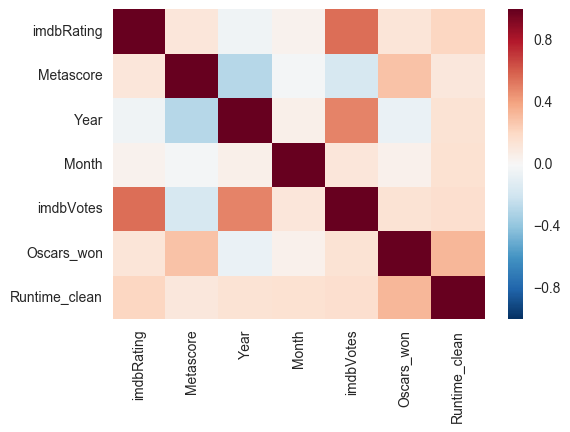

In [215]:
sns.heatmap(df2[rel_columns[:19]].corr());

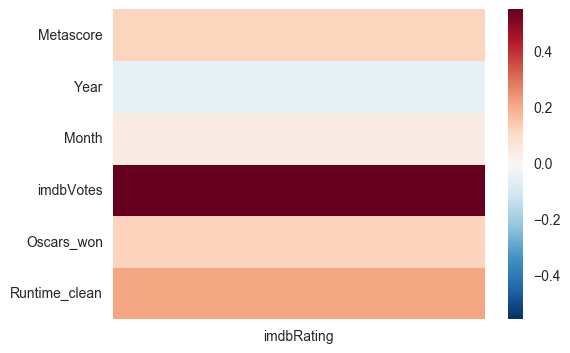

In [216]:
sns.heatmap(df2[rel_columns[:19]].corr()[["imdbRating"]].iloc[1:]);

In [217]:
df2.to_csv("clean_data.csv", encoding="utf-8")

# Model: Define training set

In [227]:
len(df2["Month"])

250

In [228]:
df3 = df2.copy()

In [309]:
df3 = df3[df3["Month"].notnull() == True]

In [310]:
X = df3.copy()[features]
y = df3.copy()["imdbRating"]

In [311]:
scale_col = ["Year", "Month", "imdbVotes", "Oscars_won", "Runtime_clean"]
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X[scale_col])

In [312]:
for i in scale_col:
    X["Scaled_"+i] = X_scaled[:,scale_col.index(i)]

In [313]:
X = X.iloc[:,5:]

In [314]:
scaler2 = preprocessing.StandardScaler()
y_scaled = scaler2.fit_transform(y.values.reshape(-1,1))

In [315]:
y = np.ravel(y_scaled)

# Model: Fit and evaluate model
Bonus: How is model at risk of overfitting?

In [316]:
cv = model_selection.StratifiedKFold()

In [317]:
cv.split(X,y)

<generator object split at 0x11c25c690>

In [320]:
gs = model_selection.GridSearchCV(ensemble.RandomForestRegressor(random_state=1),
                                  {"n_estimators": np.arange(10,20,2), 
                                   "criterion": ["mse", "mae"], 
                                   "min_samples_split": np.arange(5,15,1), 
                                   "min_samples_leaf": np.arange(5,15,1)},
                                  cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([10, 12, 14, 16, 18]), 'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'criterion': ['mse', 'mae'], 'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [321]:
gs.best_params_

{'criterion': 'mse',
 'min_samples_leaf': 5,
 'min_samples_split': 11,
 'n_estimators': 10}

In [322]:
rf = gs.best_estimator_

In [323]:
y_pred = rf.predict(X)

In [324]:
check = pd.DataFrame([df3["imdbRating"], scaler2.inverse_transform(y_pred)], index=["actual", "predicted"]).T

In [325]:
rf.score(X,y)

0.73436068367574747

In [326]:
metrics.mean_squared_error(y, y_pred)

0.26563931632425264

In [327]:
check

,actual,predicted
0,9.3,8.840684
1,9.2,8.859906
2,9.0,8.627081
3,9.0,8.819771
4,8.9,8.547880
5,8.9,8.685264
6,8.9,8.880128
7,8.9,8.853342
8,8.9,8.565762
9,8.8,8.840684


# Present: Describe findings in blog post: summary, model, recommendations